## Домашнее задание №9
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [3]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [18]:
from torch.nn import RNN
from functools import cache

In [5]:
# do not change the code in the block below
# __________start of block__________
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("{} device is available".format(device))
# __________end of block__________

cpu device is available


#### 1. Загрузка данных.

In [6]:
# do not change the code in the block below
# __________start of block__________
# !wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r', encoding="utf8") as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

In [7]:
text

'\ni\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»\n\n\n\nii\n\nтак думал молодой повеса,\nлетя в пыли на почтовых,\nвсевышней волею зевеса\nнаследник всех своих родных. —\nдрузья людмилы и руслана!\nс героем моего романа\nбез предисловий, сей же час\nпозвольте познакомить вас:\nонегин, добрый мой приятель,\nродился на брегах невы,\nгде, может быть, родились вы\nили блистали, мой читатель;\nтам некогда гулял и я:\nно вреден север для меня\n\n\niii\n\nслужив отлично-благородно,\nдолгами жил его отец,\nдавал три бала ежегодно\nи промотался наконец.\nсудьба евгения хранила:\nсперва madame за ним ходила,\nпотом monsieur ее сменил;\nребенок был резов, но 

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [8]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ["<sos>"]
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [68]:
# do not change the code in the block below
# __________start of block__________
batch_size = 1
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx["<sos>"]


def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size * seq_length - 1)
    data = np.array(
        text_encoded[start_index : start_index + batch_size * seq_length]
    ).reshape((batch_size, -1))
    yield np.hstack((start_column, data))


# __________end of block__________

Пример батча:

In [69]:
a = next(generate_chunk())
a

array([[83, 50, 54,  7,  0,  0,  0,  0, 40, 28,  0,  0, 58, 59,  1, 68,
        63, 59,  1, 46, 72,  1, 58, 53,  1, 46, 72, 56, 59,  5,  1, 68,
        53, 63, 45, 63, 50, 56, 73,  5,  0, 64, 47, 72,  2,  1, 56, 75,
        46, 59, 47, 58, 53, 55,  1, 57, 59, 56, 59, 49, 59, 54,  5,  0,
        60, 59, 74, 63,  5,  1, 52, 45, 49, 64, 57, 68, 53, 47, 72, 54,
         1, 57, 50, 68, 63, 45, 63, 50, 56, 73,  5,  0, 64, 46, 53, 63,
         1, 60, 61, 53, 76]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [11]:
model = RNN(input_size=101,
            hidden_size=500,
            num_layers=5,
            nonlinearity='tanh',
            bias=True,
            batch_first=False,
            device=device)

In [169]:
# opt = torch.optim.Adam(model.parameters())
# loss = torch.nn.CrossEntropyLoss(ignore_index=None)  # ???
# history = []
def fit(model: RNN, epochs, opt=torch.optim.Adam(model.parameters()), lossf=F.nll_loss, history=[]):
    #for i, batch in enumerate([torch.tensor(next(generate_chunk()), dtype=torch.int64) for j in range(epochs)]):
    for epoch in range(epochs):
        batch = torch.tensor(next(generate_chunk()), dtype=torch.float32)
        inputs = batch
        targets = batch
        outputs = model(inputs)[1]
        loss = lossf(outputs[:, 1:].contiguous().view(-1), targets[:, :-1].contiguous().view(-1))  # ???
        opt.zero_grad()
        loss.backward()
        opt.step()
        print(f"epoch {epoch}, loss {loss.item():.4f}")


fit(model, 3)
#model.train(True)
#model.train(False)
# fit(model, 3)
# model.train(False)
# a = model(torch.tensor([token_to_idx[token] for token in " мой дядя самых честных правил"], dtype=torch.float32).reshape((1, -1)))

# a[0].shape
#torch._C._nn.cross_entropy_loss()

RuntimeError: size mismatch (got input: [2495], target: [500])

In [12]:
batch = torch.tensor(next(generate_chunk()), dtype=torch.float32, requires_grad=True)
inputs = batch

model.forward(inputs)

(tensor([[-0.0546, -0.1164,  0.0799,  ...,  0.1731, -0.0640, -0.1191],
         [-0.1783, -0.0148, -0.0564,  ...,  0.0463,  0.0433,  0.1377],
         [ 0.1374, -0.1261,  0.0094,  ...,  0.0115,  0.1053, -0.0451],
         ...,
         [-0.1432, -0.2177,  0.0880,  ...,  0.0733,  0.0533,  0.1277],
         [-0.0758, -0.0845, -0.1165,  ...,  0.0573,  0.0055,  0.0517],
         [ 0.0111, -0.0915, -0.0537,  ...,  0.1811,  0.1001,  0.0010]],
        grad_fn=<SqueezeBackward1>),
 tensor([[-1.0000, -0.9626, -1.0000,  ...,  1.0000, -1.0000,  1.0000],
         [-0.7114,  0.4206,  0.1608,  ...,  0.7840,  0.5164, -0.7394],
         [-0.5048, -0.4648, -0.0346,  ..., -0.2767, -0.4462, -0.0771],
         [-0.2567,  0.0047,  0.0255,  ...,  0.1597,  0.1362,  0.0707],
         [ 0.0111, -0.0915, -0.0537,  ...,  0.1811,  0.1001,  0.0010]],
        grad_fn=<SqueezeBackward1>))

In [ ]:
model.eval()
out = model(torch.tensor([token_to_idx[token] for token in " мой дядя самых честных правил"], dtype=torch.float32).reshape((1, -1)))[0]
_, predicted = torch.max(out, 1)
res = idx_to_token[*[idx for idx in predicted.item()]]

In [14]:
def ed_vec(i, size):
    data = torch.zeros((size))
    data[i] = 1
    return data

In [19]:
class Adam():
    def __init__(self, x_, t=100, rho=0.1, beta=0.1, lr=3e-4, eps=1e-6):
        self.x_ = x_
        self.t = t
        self.rho = rho
        self.beta = beta
        self.lr = lr
        self.eps = eps
        self.v = np.zeros(x_.shape[0])
        self.cache = np.zeros(x_.shape[0])
    
    def step(self, df):
        self.v *= self.rho 
        self.v += ((1 - self.rho) * df(self.x_))

        self.cache *= self.beta
        self.cache += (1 - self.beta) * np.square(df(self.x_))

        self.x_ -= self.lr * self.v / (self.cache + self.eps)

        return self.x_

In [ ]:
def vector_to_shapes(vec, shapes: list[np.ndarray[int]]) -> list[torch.Tensor]:
    for shape in shapes:
        cut, vec = vec[:np.prod(shape)]


In [90]:
class VanillaRNN:
    def __init__(self, input_size=1, hidden_size=50, output_size=84):
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
        self.W_hidden = torch.randn((hidden_size, hidden_size + input_size)) /100
        self.b_hidden = torch.zeros((hidden_size))
        self.W_out = torch.randn((output_size, hidden_size))/100
        self.b_out = torch.zeros((output_size))

        self.context = torch.zeros((self.hidden_size), dtype=torch.float32)
        self.X = [torch.zeros((hidden_size + input_size)), torch.zeros((hidden_size)), torch.zeros((hidden_size)),torch.zeros((output_size)), torch.zeros((output_size))]
        # Какие иксы чему равны записано у меня в тетрадочке
        self.total_parameters = hidden_size*(hidden_size+input_size + 1) + output_size*(hidden_size + 1)

        # optimizer parameters
        self.rho = 0.1
        self.beta = 0.1
        self.lr = 3e-4
        self.eps = 1e-6

        self.v = np.zeros(self.total_parameters)
        self.cache = np.zeros(self.total_parameters)
        self.gradients = np.zeros(self.total_parameters)

        self.results = []
        pass
    
    def optimizer_step(self):
        x_ = self.all_weights_flat()
        self.v *= self.rho
        self.v += ((1 - self.rho) * self.gradients)

        self.cache *= self.beta
        self.cache += (1 - self.beta) * np.square(self.gradients)

        x_ -= self.lr * self.v / (self.cache + self.eps)
        self.set_weights_from_flat(x_)
        #self.gradients = np.zeros(self.total_parameters)  # ОБНУЛЕНИЕ ГРАДИЕНТА

    def cell(self, input: int) -> int:
        self.X[0] = torch.tensor(np.append(self.context, input)).detach().numpy()
        self.X[1] = self.W_hidden.float() @ self.X[0] + self.b_hidden.float()
        self.X[2] = torch.tanh(self.X[1]).float()
        self.X[3] = self.W_out.float() @ self.X[2] + self.b_out.float()
        self.X[4] = torch.tensor(self.softmax(self.X[3])).float()

        self.context = self.X[2]
        return self.X[4]
    
    # def forward(self, input) -> "np._ArrayLikeInt":
    #     self.context = torch.zeros((self.hidden_size), dtype=torch.float32)
    #     result = []
    #     for x in input:
    #         result.append(self.cell(x))
    #     return np.array(result)

    def fit(self, epochs):
        self.history = []
        for epoch in range(epochs):
            print(f'epoch {epoch} start')
            batch = next(generate_chunk())
            for line in batch:
                print(line[0])
                self.context = torch.zeros((self.hidden_size), dtype=torch.float32)
                result = ""
                for i, token_idx in enumerate(line[:-1]):
                    print(f'{i} of {len(line[:-1])}')
                    probabilities = self.cell(token_idx)
                    result += idx_to_token[np.argmax(probabilities).item()]
                    loss = self.loss(target=line[i+1])
                    self.back_prop(target=line[i+1])
                    self.optimizer_step()
                    self.history.append([loss])
                    clear_output(True)
                    plt.plot(self.history)
                    plt.show()
                self.results.append(result)
            print(f'epoch {epoch} end')
            

    def loss(self, target):
        return -torch.log(self.X[4][target]).float()
    
    def loss_grad(self, x, target):
        '''x - 1d
           target - int
           result - 1d'''
        return -1./self.softmax(x)[target] * self.softmax_grad(x)[target].float()
    
    @cache
    def softmax_grad(self, vec):
        '''vec - 1d
           result - 2d'''
        sumexp = torch.sum(torch.exp(vec))
        return torch.tensor(( [[-torch.exp(vec[i])*torch.exp(vec[j]) / sumexp**2 + (torch.exp(vec[i])/sumexp if i==j else 0.) for j in range(len(vec))]for i in range(len(vec))])).float()
        
    def tanh_grad(self, vec):
        '''vec - 1d
           result - 2d'''
        return torch.diag(1./torch.cosh(vec)**2).float()
    
    def product_grad_W(self, vec, dim1, dim2):
        '''vec - 1d (dim2)
           dim1, dim2 - размеры матрицы W
           result - 2d (dim1, dim1*dim2)'''
        res = torch.zeros((dim1, dim1*dim2), dtype=torch.float32)
        for i in range(dim1):
            for j in range(dim2):
                res[i][i*dim2 + j] = vec[j]
        return res.float()

    def product_grad_x(self, W):
        return W.float()
    
    def back_prop(self, target):
        self.b_out_grad = self.loss_grad(self.X[4], target).float() @ self.softmax_grad(self.X[3]).float()

        self.w_out_grad = self.b_out_grad @ self.product_grad_W(self.X[2], *self.W_out.shape)

        self.b_hid_grad = self.b_out_grad @ self.product_grad_x(self.W_out) @ self.tanh_grad(self.X[1])

        self.w_hid_grad = self.b_hid_grad @ self.product_grad_W(self.X[0], *self.W_hidden.shape)

        assert len(self.b_out_grad.shape) == len(self.w_out_grad.shape) == len(self.b_hid_grad.shape) == len(self.w_hid_grad.shape) == 1

        self.gradients = np.concatenate((self.w_hid_grad, self.b_hid_grad, self.w_out_grad, self.b_out_grad))
        assert len(self.gradients) == self.total_parameters
    
    @staticmethod
    def softmax(x):
        return np.exp(x)/sum(np.exp(x))
    # def fit(self, epochs):
    #     opt = torch.optim.Adam(self.parameters())
    #     lossf = F.nll_loss
    #     history = []
    #     for epoch in range(epochs):
    #         batch = next(generate_chunk())
    #         input = batch
    #         result = torch.tensor( [self.forward(x) for x in input] , requires_grad=True)
    #         #print(result.shape)
    #         #target = torch.tensor(batch)
    #         target = torch.tensor( [ [ed_vec(batch[i][j], 84).data.numpy() for j in range(batch.shape[1])] for i in range(batch.shape[0])], requires_grad=True)
    #         #print(target.shape)
    #         loss = nn.CrossEntropyLoss()(result[:, 1:].contiguous().view(-1), target[:, :-1].contiguous().view(-1))
    #         #loss = F.cross_entropy(target[:, :-1].contiguous().view(-1), target[:, :-1].contiguous().view(-1))

    #         loss.backward()
    #         opt.step()
    #         opt.zero_grad()

    #         history.append(loss.cpu().data.numpy())
    #         print(loss.cpu().data.numpy())
    #         plt.plot(history, label='loss')
    #         plt.legend()
    #         plt.show()
    #         clear_output(True)

    def all_weights_flat(self):
        return torch.concat((self.W_hidden.flatten(), self.b_hidden, self.W_out.flatten(), self.b_out))
    
    def set_weights_from_flat(self, weights):
        assert len(weights) == self.total_parameters
        
        self.W_hidden, weights = torch.reshape(weights[:np.prod(self.W_hidden.shape)], self.W_hidden.shape), weights[np.prod(self.W_hidden.shape):]
        self.b_hidden, weights = torch.reshape(weights[:np.prod(self.b_hidden.shape)], self.b_hidden.shape), weights[np.prod(self.b_hidden.shape):]
        self.W_out, weights = torch.reshape(weights[:np.prod(self.W_out.shape)], self.W_out.shape), weights[np.prod(self.W_out.shape):]
        self.b_out, weights = torch.reshape(weights[:np.prod(self.b_out.shape)], self.b_out.shape), weights[np.prod(self.b_out.shape):]

        assert len(weights) == 0

In [97]:
imba = VanillaRNN()

In [17]:
vec = torch.tensor([1., 0., 0., 0., 0.])
imba.loss_grad(vec)

tensor([-0., inf, inf, inf, inf])

In [ ]:
input = "го в майнкрафт"
input_int = [token_to_idx[token] for token in input]

out = imba.forward(input_int)
out = [x.item() for x in out]
res = [idx_to_token[idx] for idx in out]
print(out, "\n", res)

[16, 16, 29, 16, 22, 16, 16, 16, 16, 16, 16, 16, 16, 16] 
 [']', ']', 'm', ']', 'e', ']', ']', ']', ']', ']', ']', ']', ']', ']']


C:\Users\xiaomi\AppData\Local\Temp\ipykernel_20016\2597924372.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  context = torch.tanh(self.W_hidden@context + self.b_hidden)


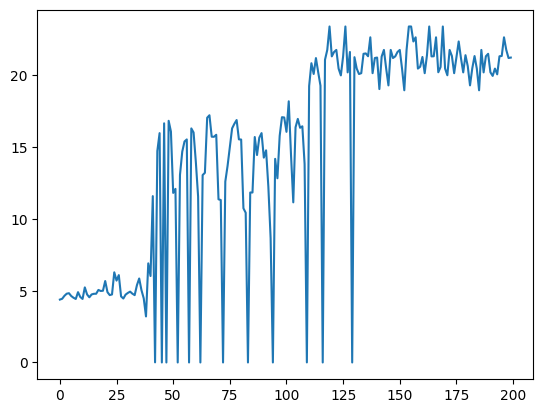

epoch 1 end


In [98]:
imba.fit(2)

In [99]:
imba.results

['шпооэт,т\nн  удррых стин,,ни каартнн,\nо  ниииииииииииииииииииииииииииииииииииииииииииииииииииииииииии',
 'ииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииииии']

In [96]:
token_to_idx['т']

63

In [242]:
params = [1, 50, 84]
a = iter(params)
#next(a)

In [ ]:
type(next(model.parameters()))

torch.nn.parameter.Parameter

torch.nn.parameter.Parameter

In [ ]:
import json
f = open("out.json")
json.dump(model.parameters(), f)
# for i in model.parameters():
#     print(i[1].shape)

In [246]:
type(model.parameters())

generator

In [219]:
len("го в майнкрафт")

14

In [220]:
len(res)

14

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

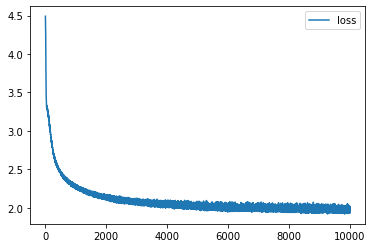

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(
    char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    if seed_phrase is not None:
        x_sequence = [token_to_idx["<sos>"]] + [
            token_to_idx[token] for token in seed_phrase
        ]
    else:
        x_sequence = [token_to_idx["<sos>"]]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any

    # your code here

    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(
    generate_sample(
        model, " мой дядя самых честных правил", max_length=500, temperature=0.8
    )
)

<sos> мой дядя самых честных правилас;



xiv

но как потокой.



xii

«я свобред не словавран в скорей,
для с посвялесь мне моловой,
те ты,
перегиной в тям праздной
и привезут перваю вся вновся сквозь ти стала сблился,
и старый свимарной таня обратель любова не когда и нет волностье нежной
тишен,
перестоком.
«поже постаничив очествы
в и старько забаньем и заковенью,
ее своя моднать наводушта;
какой нет поли своем горозный и быле и, законно он ходушних недважный плая
с за стра.



xvii




xxvi

все 


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = " мой дядя самых честных правил"

In [ ]:
generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]

In [ ]:
output = {key: ','.join([str(x) for x in list(data.item()[key])]) for key in 'train', 'test'}

In [ ]:
# do not change the code in the block below
# __________start of block__________

if "generated_phrases" not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all(
        [x in set(tokens) for x in set(list(phrase))]
    ), "Unknown tokens detected, check your submission!"


submission_dict = {"token_to_idx": token_to_idx, "generated_phrases": generated_phrases}

np.save("submission_dict_hw09.npy", submission_dict, allow_pickle=True)
print("File saved to `submission_dict_hw09.npy`")
# __________end of block__________

На этом задание завершено. Поздравляем!